In [1]:
from scipy.io import loadmat
import networkx as nx
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import time
from sklearn.decomposition import KernelPCA
from Functions import *
from Triangles import *
from Laplacians import *
#cmap = plt.cm.get_cmap("jet")
#cmap = plt.cm.get_cmap("RdYlBu")
#cmap = plt.cm.get_cmap("cool")
cmap = plt.cm.get_cmap("viridis")
%matplotlib inline

# Load Data

In [2]:
path = "../Source/APBC2018/APBC-GitHub.mat"
name_path= "../Source/APBC2018/drug_name_568.txt"
data=loadmat(path)
name=pd.read_csv(name_path, header=None)

file = open(name_path, "r")
name =file.read()
name = name.split("\n")
file.close()

def load_matrix(k, root="./matrices/"):
    path_H=root+"H"+str(k)+".mat"
    path_W=root+"W"+str(k)+".mat"
    H=loadmat(path_H)
    W=loadmat(path_W)
    
    H=H["H"]
    W=W["W"]
    return H,W

In [3]:
DDI_binary=data["DDI_binary"] # adjacncy matrix
DDI_triple=data["DDI_triple"] # signed network
offisides_feature=data["offsides_feature"]
pca_offisides=data["pca_offisides"]
pca_structure=data["pca_structure"]
structure_feature=data["structure_feature"] #feature vector based on PubChem structure descriptor

In [4]:
offisides_feature.shape

(568, 9149)

In [5]:
#check if data was loaded correct
assert offisides_feature.shape == (568, 9149)
assert DDI_binary.shape == (568, 568)
assert np.all(DDI_triple**2 == DDI_binary)

# Build Networkx Graph

In [6]:
G_binary = nx.from_numpy_matrix(DDI_binary)

In [7]:
name_mapping= {i: name[i] for i in range(len(G_binary.nodes))}
Gb = nx.relabel_nodes(G_binary, name_mapping)

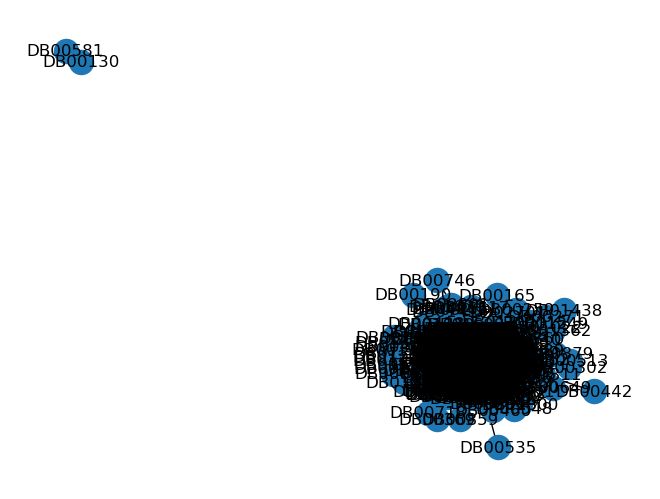

In [8]:
nx.draw(Gb, with_labels=True)

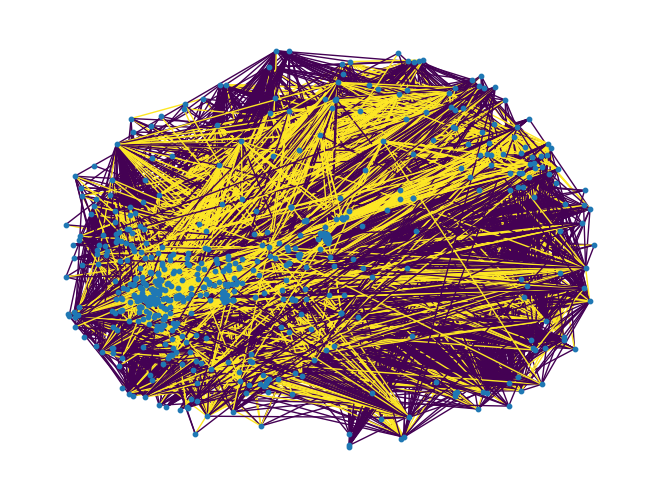

In [9]:
Gt=nx.from_numpy_matrix(DDI_triple)
name_mapping= {i: name[i] for i in range(len(Gt.nodes))}
Gt= nx.relabel_nodes(Gt, name_mapping)
edges,w = zip(*nx.get_edge_attributes(Gt,'weight').items())
nx.draw(Gt, with_labels=False, edge_color=w, node_size=10)
G=Gt
A = nx.to_numpy_array(Gt)
BC=False

## Look at largest connected Graph

In [ ]:
start=time.time()
n_ub, n_wb, n_sb, Ntri = triad_types(Gt)
print("unbalanced: {}".format(n_ub))
print("weakly balanced: {}".format(n_wb))
print("strongly balanced: {}".format(n_sb))
print("total triangles: {}".format(Ntri))
print("time: {} s".format(time.time()-start))

In [ ]:
start=time.time()
cbi_global=CBI(Gt, np.ones(len(list(Gt.nodes()))))
print("time: {} s".format(time.time() -start))
print("cbi global: {}".format(cbi_global))

# Analysis of Graph

In [ ]:
def compute_CCDF(data, normalize=True):
    x = np.sort(data)[::-1]
    counts = x.size - np.searchsorted(x[::-1],x[::-1],side='left') # we need searchsorted to take into account duplicated values
    if normalize:
        counts = np.true_divide(counts, counts[-1])
    return x[::-1], counts/counts.max()


Gtdeg=np.array([n for (k,n) in Gt.degree()])
Gx, GcountsCCDF = compute_CCDF(Gtdeg)
plt.plot(Gx, GcountsCCDF)



## Centralities

In [ ]:
#degree centrality
#DegCent=nx.degree_centrality(Gt)

#Eigenvector centrality
EigCent = nx.eigenvector_centrality(G_binary)

#Betweeness centrality
BetCent = nx.betweenness_centrality(G_binary)

#Closeness centrality
ClosCent = nx.closeness_centrality(G_binary) 



In [ ]:
plt.hist(list(EigCent.values()))

In [ ]:
plt.hist(list(ClosCent.values()))

In [ ]:
plt.hist(list(BetCent.values()), bins=100)
plt.show()

In [ ]:
centralites_titles=[ "Eigenvector Centrality", "Betweenness Centrality", "Closeness Centrality"]

centralities=[ EigCent, BetCent, ClosCent]

In [ ]:
#Weitghts
We, W_pos, W_neg = weights(Gt)

#extract degrees
d, d_pos, d_neg = degrees(Gt)

D= np.diag(d)

D_pos = np.diag(d_pos)
D_neg = np.diag(d_neg)

In [ ]:

c = "seismic"
plt.figure(figsize=(10,8))

plt.subplot(1,3,1)
plt.imshow(We, vmin=-1, vmax=1)
plt.title("W")
plt.set_cmap(c)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(W_pos,vmin=-1, vmax=1)
plt.title("$W^+$")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(W_neg*-1, vmin=-1, vmax=1)
plt.title("$W^-$")

plt.set_cmap(c)
plt.axis('off')

# Clusterings

## plot functions

### Plot clusters

In [ ]:
def plot_clusters(Gt, colors, BC=True): #biggest component
     
    pca1=KernelPCA(n_components=3)
    pca2=KernelPCA(n_components=3)
    
    if BC:
        pca_struc=pca1.fit_transform(structure_featureBC)
        pca_offi=pca2.fit_transform(offisides_featureBC)
    else:
        pca_struc=pca1.fit_transform(structure_feature)
        pca_offi=pca2.fit_transform(offisides_feature)
  
    
    c=cmap(colors/colors.max())
        
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.scatter(pca_struc[:,0], pca_struc[:,1], c=c)
    plt.xlabel("1st component")
    plt.ylabel("2nd component")
    plt.title("Structure Feature reduced")
    
    plt.subplot(2,2,2)
    plt.scatter(pca_struc[:,0], pca_struc[:,2], c=c)
    plt.xlabel("1st component")
    plt.ylabel("3rd component")
    plt.title("Structure Feature reduced")



    plt.subplot(2,2,3)
    plt.scatter(pca_offi[:,0], pca_offi[:,1], c=c)
    plt.xlabel("1st component")
    plt.ylabel("2nd component")
    plt.title("Offiside Feature reduced")
    
    plt.subplot(2,2,4)
    plt.scatter(pca_offi[:,0], pca_offi[:,2], c=c)
    plt.xlabel("1st component")
    plt.ylabel("3rd component")
    plt.title("Offiside Feature reduced")
    
    plt.tight_layout()
    plt.show()

    return

        
def cluster_sizes(label):
    #d= np.unique(label, return_counts=True)
    #cs = {d[0][i]:d[1][i] for i in range(d[0].shape[0])}
    _, cs= np.unique(label, return_counts=True)
    
    print(cs)
    return cs 

### Plot Degrees and Labels

In [ ]:
def plot_labels(L_signed, d,d_pos, d_neg, label, set_lim=False, xlim=[-1,1], ylim=[-1,1], title=None, saveimage=False):
    pca=KernelPCA(n_components=3)
    pca_L = pca.fit_transform(L_signed)
    
    vmaxd=np.max(d)
    vmind=np.min(d)
    
    vmaxdiff=np.max(d_pos-d_neg)
    vmindiff=np.min(d_pos-d_neg)
    
    dnorm = colors.Normalize(vmin=vmind, vmax=vmaxd)
    c=dnorm(d)
    d_color=cmap(c)

    cdiff= (d_pos -d_neg)
    cdiffnorm=colors.Normalize(vmin=vmindiff, vmax=vmaxdiff)
    cdiff = cdiffnorm(cdiff)
    diff_color=cmap(cdiff)
  
    fontsize=13
    title_size=15
    
    plt.figure(figsize=(15,8))


    label_color=cmap(label/label.max())
    
    fig=plt.figure(figsize=(15,10))
    plt.subplot(2,3,1)
    plt.scatter(pca_L[:,0], pca_L[:,1], c = d_color)
    plt.xlabel("X", fontsize=fontsize)
    plt.ylabel("Y", fontsize=fontsize)
    plt.title("degree", size=title_size)
    plt.locator_params(axis='y', nbins=6)
    plt.locator_params(axis='x', nbins=6)
    plt.xticks(fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)
    
    if set_lim:
        plt.xlim(xlim)
        plt.ylim(ylim)
    
    plt.subplot(2,3,2)
    plt.title("pos-neg", size=title_size)
    plt.scatter(pca_L[:,0], pca_L[:,1], c= diff_color)
    plt.xlabel("X", fontsize=fontsize)
    plt.ylabel("Y", fontsize=fontsize)
    plt.locator_params(axis='y', nbins=6)
    plt.locator_params(axis='x', nbins=6)
    plt.xticks(fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)
    
    if set_lim:
        plt.xlim(xlim)
        plt.ylim(ylim)
        
    plt.subplot(2,3,3)
    plt.scatter(pca_L[:,0], pca_L[:,1], c = label_color)
    plt.xlabel("X", fontsize=fontsize)
    plt.ylabel("Y", fontsize=fontsize)
    plt.title("label", size=title_size)
    plt.locator_params(axis='y', nbins=6)
    plt.locator_params(axis='x', nbins=6)
    plt.xticks(fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)
    if set_lim:
        plt.xlim(xlim)
        plt.ylim(ylim)
        
    plt.subplot(2,3,4)
    plt.scatter(pca_L[:,0], pca_L[:,2], c = d_color)
    plt.title("degree", size=title_size)
    plt.xlabel("X", fontsize=fontsize)
    plt.ylabel("Z", fontsize=fontsize)
    plt.locator_params(axis='y', nbins=6)
    plt.locator_params(axis='x', nbins=6)
    plt.xticks(fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)
    if set_lim:
        plt.xlim(xlim)
        plt.ylim(ylim)
    
    plt.subplot(2,3,5)
    plt.scatter(pca_L[:,0], pca_L[:,2], c= diff_color)
    plt.title("pos-neg", size=title_size)
    plt.xlabel("X", fontsize=fontsize)
    plt.ylabel("Z", fontsize=fontsize)
    plt.locator_params(axis='y', nbins=6)
    plt.locator_params(axis='x', nbins=6)
    plt.xticks(fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)
    if set_lim:
        plt.xlim(xlim)
        plt.ylim(ylim)
        
    plt.subplot(2,3,6)
    plt.scatter(pca_L[:,0], pca_L[:,2], c = label_color)
    plt.xlabel("X", fontsize=fontsize)
    plt.ylabel("Z", fontsize=fontsize)
    plt.title("label", size=title_size)
    plt.locator_params(axis='y', nbins=6)
    plt.locator_params(axis='x', nbins=6)
    plt.xticks(fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)
    if set_lim:
        plt.xlim(xlim)
        plt.ylim(ylim)
    plt.tight_layout()
    
    if (title!=None) & (saveimage==True):
        plt.savefig("./plots/"+title+".png")
    
    return fig

### Plot Centralities

In [ ]:



#######################################################################################333
def plot_centralities(L_signed, centralites, titles, set_lim=False, xlim=[-1,1], ylim=[-1,1]):
    pca=KernelPCA(n_components=3)
    pca_L = pca.fit_transform(L_signed)
    
    
    for i,c in enumerate(centralities):
        
        col= np.asarray(list(c.values()))
        vmin=col.min()
        vmax=col.max()
        
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        col=cmap(norm(col))
        
        fig=plt.figure(figsize=(10,5))
        
        plt.suptitle(titles[i])
        plt.subplot(1,2,1)
        plt.scatter(pca_L[:,0], pca_L[:,1], c = col)
        plt.xlabel("1st component")
        plt.ylabel("2nd component")
        
        if set_lim:
            plt.xlim(xlim)
            plt.ylim(ylim)

        plt.subplot(1,2,2)
        plt.scatter(pca_L[:,0], pca_L[:,2], c= col)
        plt.xlabel("1st component")
        plt.ylabel("3rd component")
        
        if set_lim:
            plt.xlim(xlim)
            plt.ylim(ylim)

    plt.autoscale(enable=True, axis='both', tight=None)
    
    return


### Plot Weights

In [ ]:
def draw_communities(label):
    values, count = np.unique(label, return_counts=True)
    c_sum=0
    
    for i,c in enumerate(count):
        if i<count.shape[0]-1:
            c_sum += c
            plt.axvline(x=c_sum, c="black")
            plt.axhline(y=c_sum, c = "black")
        
    return


def Weight_plots(W, W_pos, W_neg, label, title=None, saveimage=False):
    idx=np.argsort(label)
    
    W=W[idx,:]
    W=W[:, idx]
    
    W_pos=W_pos[idx,:]
    W_pos=W_pos[:,idx]
    
    W_neg=W_neg[idx,:]
    W_neg=W_neg[:,idx]
    
    c = "seismic"
    plt.figure(figsize=(12,8))

    plt.subplot(1,3,1)
    plt.imshow(W, vmin=-1, vmax=1)
    draw_communities(label)
    plt.title("W")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(W_pos, vmin=-1, vmax=1)
    plt.title("$W^+$")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(W_neg*-1, vmin=-1, vmax=1)
    plt.title("$W^-$")

    plt.set_cmap(c)
    plt.axis('off')
    
    plt.tight_layout()
    if (title != None) &(saveimage==True):
        plt.savefig("./plots/"+title+".png")
    
    return

## Spectral Clustering

unsigned Laplacian Matrix
$ L = D-A $

In [ ]:
k=10
L_signed=D-A
label_signed = spectral_clustering(L_signed, k)

In [ ]:
#plot_clusters(Gt, label_signed, BC)

In [ ]:
plot_labels(L_signed, d,d_pos, d_neg, label_signed, True, [-5,5], [-5, 5])

In [ ]:
#CBI(Gt, colors)

In [ ]:
cluster_sizes(label_signed)

## Laplacians on Signed Graphs

Balance Ratio
$$ L_{BR} = D^+ - W^+ + W^-$$

Normalized Laplacian
$$ L_{BN} = \bar{D}L_{BR}$$

Signed Ratio 
$$ L_{SR}= \bar{D} - W^+ + W^-$$

Normalized Laplacian
$$ L_{SN} = \bar{D}^{-1/2}L_{SR}\bar{D}^{-1/2} $$

Arithmetic mean Laplacian
 $$ L_{AM} = L^+_{sym} + Q^-_{sym}$$
 
 Geometric Mean Laplacian
$$ L_{GM} = L^+_{sym}\#Q^-_{sym}$$

In [ ]:

k=6
saveimage=True

L_BR = build_L_BR(W_pos, W_neg)
label_BR = spectral_clustering(L_BR, k)

L_BN = build_L_BN(W_pos, W_neg)
label_BN = spectral_clustering(L_BN, k)

L_SR = build_L_SR(W_pos, W_neg)
label_SR = spectral_clustering(L_SR, k) #2

L_SN=build_L_SN(W_pos, W_neg)#np.diag(np.array(d_all)**(-0.5)) @L_SR @ np.diag(np.array(d_all)**(-0.5))
#L_SN = np.diag(d**(-0.5)) @L_SR @ np.diag(d**(-0.5))
label_SN = spectral_clustering(L_SN,k)

L_AM = build_L_AM(W_pos, W_neg)
label_AM = spectral_clustering(L_AM, k)

L_GM = build_L_GM(W_pos, W_neg)
label_GM = spectral_clustering(L_GM,k)


H,W=load_matrix(k)
label_H=np.argmax(H, axis=0)

In [ ]:
print("BR")
BR_cs=cluster_sizes(label_BR)
print("BN")
BN_cs=cluster_sizes(label_BN)
print("SR")
SR_cs=cluster_sizes(label_SR)
print("SN")
SN_cs=cluster_sizes(label_SN)
print("AM")
AM_cs = cluster_sizes(label_AM)
print("GM")
GM_cs = cluster_sizes(label_GM)
print("semi-NMF")
H_cs = cluster_sizes(label_H)



### BR

In [ ]:
plot_clusters(Gt, label_BR, BC)

In [ ]:
f=plot_labels(L_BR, d,d_pos, d_neg, label_BR, True, [-5,5], [-5, 5])

In [ ]:
plot_centralities(L_BR, centralities, centralites_titles, set_lim=True, xlim=[-10,10], ylim=[-10,40])

In [ ]:
Weight_plots(We, W_pos, W_neg, label_BR)

In [ ]:
start=time.time()
cbi_BR=CBI(Gt,label_BR)
print("time: {} s".format(time.time() -start))
print("cbi BR: {}".format(cbi_BR))

### BN

In [ ]:
plot_clusters(Gt,label_BN, BC)

In [ ]:
f=plot_labels(L_BN, d,d_pos, d_neg, label_BN, True, [-0.1,0.1], [-0.1, 0.1], title="L_BN_degrees_Zoom")

In [ ]:
plot_centralities(L_BN , centralities, centralites_titles, set_lim=True, xlim=[-0.1,0.1], ylim=[-0.1, 0.1])

In [ ]:
Weight_plots(We, W_pos, W_neg, label_BN)

In [ ]:
start=time.time()
cbi_BN=CBI(Gt,label_BN)
print("time: {} s".format(time.time() -start))
print("cbi BN: {}".format(cbi_BN))

### SR

In [ ]:
Weight_plots(We, W_pos, W_neg, label_SR)

In [ ]:
plot_clusters(Gt, label_SR, BC)
    

In [ ]:
plot_labels(L_SR, d,d_pos, d_neg, label_SR, True, [-5,5], [-5, 5])

In [ ]:
plot_centralities(L_SR, centralities, centralites_titles, True, [-5,5], [-5, 5])

In [ ]:
start=time.time()
cbi_SR=CBI(Gt,label_SR)
print("time: {} s".format(time.time() -start))
print("cbi SR: {}".format(cbi_SR))

### SN

In [ ]:
Weight_plots(We, W_pos, W_neg, label_SN, "L_SN_Weights")

In [ ]:
plot_clusters(Gt, label_SN, BC)

In [ ]:
f=plot_labels(L_SN, d,d_pos, d_neg, label_SN, True, [-0.02,0.01], [-0.3, 0.3], "L_SN_degrees")

In [ ]:
plot_centralities(L_SN, centralities, centralites_titles,True, [-0.02,0.01], [-0.3, 0.3])

In [ ]:
start=time.time()
cbi_SN=CBI(Gt,label_SN)
print("time: {} s".format(time.time() -start))
print("cbi SN: {}".format(cbi_SN))

### Arithmetic Mean Laplacian

In [ ]:
Weight_plots(We, W_pos, W_neg, label_AM)

In [ ]:
plot_clusters(Gt, label_AM, BC)

In [ ]:
f=plot_labels(L_AM, d,d_pos, d_neg, label_AM, True, [-0.5,1.0], [-0.5, 0.6], "L_AM_degrees") 

In [ ]:
plot_centralities(L_AM, centralities, centralites_titles,True, [-1,1.5], [-0.5, 0.75])

In [ ]:
start=time.time()
cbi_AM=CBI(Gt,label_AM)
print("time: {} s".format(time.time() -start))
print("cbi AM: {}".format(cbi_AM))

### Geometric Mean of Laplacian

In [ ]:
Weight_plots(We, W_pos, W_neg, label_GM, "L_GM_Weights")

In [ ]:
plot_clusters(Gt, label_GM, BC)

In [ ]:
f=plot_labels(L_GM, d,d_pos, d_neg, label_GM, False, [-1,1.5], [-0.5, 1.0], "L_GM_degrees") #default value

In [ ]:
plot_centralities(L_GM, centralities, centralites_titles, False, [-5,5], [-5, 5])

In [ ]:
start=time.time()
cbi_GM=CBI(Gt,label_GM)
print("time: {} s".format(time.time() -start))
print("cbi GM: {}".format(cbi_GM))

## semi-NMF

In [ ]:

#dG,  dG_pos, dG_neg = degrees(G)

In [ ]:
_, count = np.unique(label_H, return_counts=True)
count

In [ ]:
plot_clusters(Gt, label_H, BC)

In [ ]:
f=plot_labels(H.T, d,d_pos, d_neg, label_H, False, [-0.02,0.01], [-0.3, 0.3], "NMF_H_degrees")

In [ ]:
f=plot_labels(W, d,d_pos, d_neg, label_H, False, [-0.02,0.01], [-0.3, 0.3], "NMF_W_degrees")

In [ ]:
start=time.time()
cbi_H=CBI(Gt,label_H)
print("time: {} s".format(time.time() -start))
print("cbi H: {}".format(cbi_H))

In [ ]:
pca = KernelPCA(n_components=3)
pca_W=pca.fit_transform(W)

pca = KernelPCA(n_components=3)
pca_H=pca.fit_transform(H.T)

In [ ]:
#plot_labels(H, d,d_pos, d_neg, label_H, False, [-1,1.5], [-0.5, 1.0]) #default value

In [ ]:
Weight_plots(We, W_pos, W_neg, label_H, "NMF_Weight")

## different k

In [ ]:
def different_k(d_all, D_pos, W_pos, W_neg):
    k_list = np.arange(2,9)
    k_list=np.append( k_list, np.arange(10,70,10) )
    res=np.zeros((5, k_list.shape[0])) #7
    std = np.zeros_like(res)
    
    for i,k in enumerate(k_list):
        L_BR = build_L_BR(W_pos, W_neg)
        #label_BR = spectral_clustering(L_BR, k)

        L_BN = build_L_BN(W_pos, W_neg)
        #label_BN = spectral_clustering(L_BN, k)

        L_SR = build_L_SR(W_pos, W_neg)
        #label_SR = spectral_clustering(L_SR, k)

        L_SN= build_L_SN(W_pos, W_neg)#np.diag((d_all)**(-0.5)) @L_SR @ np.diag((d_all)**(-0.5))
        
        L_AM = build_L_AM(W_pos, W_neg)
        
        L_GM=build_L_GM(W_pos, W_neg)
        #label_SN = spectral_clustering(L_SR, k)
        
        H,W=load_matrix(k)
        
        label_H=np.argmax(H, axis=0)
        
      

        #Laplacians=[L_BR, L_BN, L_SR, L_SN, L_AM, L_GM, H]
        Laplacians=[ L_BN, L_SN, L_AM, L_GM, H]
        
        N=len(Laplacians)
        for j,L in enumerate(Laplacians):
            
            if j!=N-1:
                label=spectral_clustering(L, k)
            
            elif j==N-1: #last element corresponds to semNF
                label=label_H
               
            
            _, counts = np.unique(label, return_counts=True)
            
            diff=counts.max() - counts.min()
            res[j][i] = diff
            std[j][i] = np.std(counts)
            
    return k_list, res, std      



In [ ]:
def different_k_plot(k_list,res, std, savetitle=None, saveimage=False):
    root="./plots/"
    fontsize = 14
    #plt.figure(figsize=(15,5))
    plt.figure(figsize=(10,12))
    
    #labels=["$L_{BR}$", "$L_{BN}$", "$L_{SR}$", "$L_{SN}$", "$L_{AM}$", "$L_{GM}$", "Semi NMF"]
    
    labels=["$L_{BN}$",  "$L_{SN}$", "$L_{AM}$", "$L_{GM}$", "Semi NMF"]
    #plt.subplots(2,1,sharex='col')
    plt.subplot(2,1,1)
    for i in range(res.shape[0]):
        plt.plot(k_list, res[i,:] , "-o" ,label=labels[i])
        
    plt.title("Range of Community Sizes", fontsize=15)
    plt.ylabel("Range", fontsize=fontsize)
    plt.xlabel("No. of Communiites",  fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    
    plt.subplot(2,1,2)
    for i in range(res.shape[0]):
        plt.plot(k_list, std[i,:] , "-o" ,label=labels[i])
        
    plt.title("Standard Deviation of Community Sizes", fontsize=15)
    plt.ylabel("Standard Deviation", fontsize=fontsize)
    plt.xlabel("No. of Communiites" , fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    
    if (savetitle!=None) & (saveimage==True):
        plt.savefig(root+savetitle+".png")

In [ ]:
k_list, res, std=different_k(d, D_pos, W_pos, W_neg)

In [ ]:
different_k_plot(k_list, res, std, "Community_sizes")

# Statistics

In [ ]:
def analyze_PC(L_signed,G, border=0, left=True):
    pca=KernelPCA(n_components=3)
    pca_L = pca.fit_transform(L_signed)
    
    if left:
        first= (pca_L[:,0]<border)
        second=(pca_L[:, 1]<border)
    else:
        first= (pca_L[:,0]>border)
        second=(pca_L[:, 1]>border)
    
    nodes=list(G.nodes())
    nodes=np.asarray(nodes)
    
    sub_nodes=nodes[first]
    G_sub = G.subgraph(sub_nodes)
    start=time.time()
    
    n_ub, n_wb, n_sb, n_triangles= triad_types(G_sub)
    
    
    
    print("1st component: ")
    print(" unbalanced: {}, {}%".format(n_ub, np.round(n_ub/n_triangles*100,2)))
    print(" weakly balanced: {}, {}%".format(n_wb, np.round(n_wb/n_triangles*100, 2)))
    print(" strongly balanced: {}, {}%".format(n_sb, np.round(n_sb/n_triangles*100,2)))
    print(" total triangles: {}".format(n_triangles))
    
    sub_nodes=nodes[second]
    G_sub = G.subgraph(sub_nodes)
    
    n_ub, n_wb, n_sb, n_triangles= triad_types(G_sub)
    
    print("2nd component: ")
    print(" unbalanced: {}, {}%".format(n_ub, np.round(n_ub/n_triangles*100,2)))
    print(" weakly balanced: {}, {}%".format(n_wb, np.round(n_wb/n_triangles*100, 2)))
    print(" strongly balanced: {}, {}%".format(n_sb, np.round(n_sb/n_triangles*100,2)))
    print(" total triangles: {}".format(n_triangles))
    
    print("time: {} s".format(time.time()-start))
    
    return

def calculate_difference(group_labels, Gt):
    
    nodes=list(Gt.nodes())
    nodes=np.asarray(nodes)
    values, counts = np.unique(group_labels, return_counts=True)
    N=len(values)
    db=np.zeros((N,N))
    
    for i,ci in enumerate(values):
        for j, cj in enumerate(values):
            if ci!=cj:
                ci_nodes = (group_labels==ci)
                cj_nodes = (group_labels==cj)
                
                sub_nodes = np.concatenate( [nodes[ci_nodes], nodes[cj_nodes]])
                Gt_sub = Gt.subgraph(sub_nodes)
                R = enhancive_degressive_ratio(Gt_sub)
                if R!=None:
                    R_e, R_d= R[0], R[1]
                    db[i][j] = np.round(np.log(R_e) - np.log(R_d),3)
            elif ci==cj:
                ci_nodes = (group_labels==ci)
                
                sub_nodes = nodes[ci_nodes]
                Gt_sub = Gt.subgraph(sub_nodes)
                R = enhancive_degressive_ratio(Gt_sub)
                if R!=None:
                    R_e, R_d= R[0], R[1]
                    db[i][j] =np.round(np.log(R_e) - np.log(R_d),3)
                
    
    return db
                
def enhancive_degressive_ratio(G):
    W, W_pos, W_neg = weights(G)
    en = np.sum(W_pos)//2
    deg = np.sum(W_neg)//2
    all_pairs = np.sum(np.abs(W))//2
    if all_pairs >0.0:
        return en/all_pairs, deg/all_pairs
    else:
        return None
    

In [ ]:
analyze_PC(L_GM, Gt)

In [ ]:
analyze_PC(H.T,Gt)

In [ ]:
analyze_PC(L_SN, Gt)

In [ ]:
#analyze_PC(L_BN, Gt)

In [ ]:
analyze_PC(W, Gt)

In [ ]:
analyze_PC(W, Gt, False) #right half

In [ ]:
analyze_PC(W, Gt, 0.4, False)

In [ ]:
#analyze_PC(W, Gt, 5, False) #right half

In [ ]:
#analyze_PC(W, Gt, 5, True) #left half

In [ ]:
#analyze_PC(W, Gt, 0.4, False)

In [ ]:
print("cbi BR: {}".format(cbi_BR))
print("cbi BN: {}".format(cbi_BN))
print("cbi SR: {}".format(cbi_SR))
print("cbi SN: {}".format(cbi_SN))
print("cbi AM: {}".format(cbi_AM))
print("cbi GM: {}".format(cbi_GM))
print("cbi_H: {}".format(cbi_H))

In [ ]:
print("L_SN")
db=calculate_difference(label_SN, Gt)
print(db)
np.trace(db)


In [ ]:
print("L_GM")
db=calculate_difference(label_GM, Gt)
print(db)
print("average dw: {} ".format(np.round(np.trace(db)/db.shape[0],2)))
print("average dd: {}".format( np.round( (db.sum()- np.trace(db))/(db.shape[0]**2-db.shape[0] ) )))


In [ ]:
print("semi_NMF")
db=calculate_difference(label_H, Gt)
print(db)
print("average dw: {} ".format(np.round(np.trace(db)/db.shape[0],2)))
print("average dd: {}".format( np.round( (db.sum()- np.trace(db))/(db.shape[0]**2-db.shape[0] ) )))

# Plots for Report

## Weights

In [ ]:
def sort_W(W, label):
    
    idx=np.argsort(label)
    
    W=W[idx,:]
    W=W[:, idx]
    
   
    return W

In [ ]:

label=label_H
#values, count = np.unique(label, return_counts=True)

plt.imshow(sort_W(We,label), vmin=-1, vmax=1)
draw_communities(label)
plt.axis('off')



    
    

In [ ]:

col = 4
row =1
offset=4
c = "seismic"
plt.figure(figsize=(15,8))
magnitude=[1,-1]


for i,W in enumerate([We]):
    
    m=magnitude[i]
    plt.subplot(row,col,1+offset*i)
    plt.imshow(W*m, vmin=-1, vmax=1)
    plt.title("unordered DDI")
    plt.set_cmap(c)
    plt.axis('off')

    plt.subplot(row,col,2+i*offset)
    plt.imshow(sort_W(W, label_SN)*m, vmin=-1, vmax=1)
    draw_communities(label_SN)
    plt.title("sorted with $L_{SN}$")
    plt.set_cmap(c)
    plt.axis('off')

    plt.subplot(row,col,3+i*offset)
    plt.imshow(sort_W(W, label_GM)*m, vmin=-1, vmax=1)
    draw_communities(label_GM)
    plt.title("sorted with $L_{GM}$")
    plt.set_cmap(c)
    plt.axis('off')
    
    plt.subplot(row, col, 4+i*offset)
    plt.imshow(sort_W(W, label_H)*m, vmin=-1, vmax=1)
    draw_communities(label_H)
    plt.title("sorted with semi-NMF")
    plt.set_cmap(c)
    plt.axis('off')
    





#plt.subplot(1,3,2)
#plt.imshow(W_pos,vmin=-1, vmax=1)
#plt.title("$W^+$")
#plt.axis('off')

#plt.subplot(1,3,3)
#plt.imshow(W_neg*-1, vmin=-1, vmax=1)
#plt.title("$W^-$")

plt.set_cmap(c)
plt.axis('off')

#plt.savefig("./plots/Weights_comparisions.png")

In [ ]:
plt.imshow(sort_W(We, label_SN), vmin=-1, vmax=1)
plt.title("sorted with $L_{SN}$")
plt.set_cmap(c)


In [ ]:
plt.imshow(sort_W(We, label_SN), vmin=-1, vmax=1)
plt.title("sorted with $L_{SN}$")
plt.set_cmap(c)

plt.xlim(325,400)
plt.ylim(400,325)

## Centrality Plot

In [ ]:

L_signed = L_GM
name="L_GM"

pca=KernelPCA(n_components=3)
pca_L = pca.fit_transform(L_signed)
titles=centralites_titles


cols = len(centralities)
rows = 2
offset=cols
fig=plt.figure(figsize=(15,10))

#plt.subplots(rows, cols, sharey=True)

fontsize= 15
title_size=17

for i,c in enumerate(centralities):

    col= np.asarray(list(c.values()))
    vmin=col.min()
    vmax=col.max()

    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    col=cmap(norm(col))

    
    
    plt.subplot(rows,cols,i+1)
    plt.scatter(pca_L[:,0], pca_L[:,1], c = col)
    plt.xlabel("X", fontsize =fontsize)
    plt.ylabel("Y", fontsize =fontsize)
    plt.title(titles[i], fontsize=title_size)
    plt.xticks(fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)
   

    plt.locator_params(axis='y', nbins=6)
    plt.locator_params(axis='x', nbins=6)
    
    plt.subplot(rows,cols,i+1+offset)
    plt.scatter(pca_L[:,0], pca_L[:,2], c= col)
    plt.xlabel("X", fontsize =fontsize)
    plt.ylabel("Z", fontsize =fontsize)
    plt.title(titles[i], fontsize=title_size)
    plt.locator_params(axis='y', nbins=6)
    plt.locator_params(axis='x', nbins=6)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)



plt.tight_layout()
#plt.autoscale(enable=True, axis='both', tight=None)
#plt.savefig("./plots/"+name+"_centrality.png")